# Project: Segmenting Bank Clients 

*Project Objective*

Develop proposals aimed at improving retention of bank clients.

*Project Tasks*

•	conduct exploratory data analysis of bank clients, 

•	conduct client segmentation based on using bank products and other factors,

•	check hypotheses on the reasons for clients to churn,

•	formulating recommendations for improving client retention.

*Initial Data*

Dataset which included the data on bank clients (credit scoring data, city, gender, age, number of property objects, credit card availability, loyalty, salary estimate, churn).


## 1 Initial Data Review

Initial data review includes loading data and data description. 

In [1]:
# Importing libraries needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as mth
from scipy import stats as st
import plotly.express as px
from plotly import graph_objects as go
import seaborn as sns
import json
import requests 
from urllib.parse import urlencode

In [2]:
# Importing data 
# using api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/JVAJ9uxtV1uydQ' 
 
# getting url 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
 
# importing data to df 
download_response = requests.get(download_url) 
df = pd.read_csv(download_url) 

# displaying key information on the dataset
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


None

To ensure that there are no typing errors, let us check unique values for key variables in the dataset.

In [3]:
# Displaying unique values for cities where the bank operates
df['City'].unique()

array(['Ярославль', 'Рыбинск', 'Ростов Великий'], dtype=object)

In [4]:
# Displaying unique values for client gender
df['Gender'].unique()

array(['Ж', 'М'], dtype=object)

In [5]:
#Displaying unique values for client age
df['Age'].unique()

array([42, 41, 39, 43, 44, 50, 29, 27, 31, 24, 34, 25, 35, 45, 58, 32, 38,
       46, 36, 33, 40, 51, 61, 49, 37, 19, 66, 56, 26, 21, 55, 75, 22, 30,
       28, 65, 48, 52, 57, 73, 47, 54, 72, 20, 67, 79, 62, 53, 80, 59, 68,
       23, 60, 70, 63, 64, 18, 82, 69, 74, 71, 76, 77, 88, 85, 84, 78, 81,
       92, 83], dtype=int64)

In [6]:
#Displaying unique values for number of projects
df['Products'].unique()

array([1, 3, 2, 4], dtype=int64)

In [7]:
#Displaying unique values for loyalty indicator
df['Loyalty'].unique()

array([1, 0], dtype=int64)

In [8]:
#Displaying unique values for churn indicator
df['Churn'].unique()

array([1, 0], dtype=int64)

**Interim conclusion**

The dataset contains data on 10K clients of 'Metanprom' bank, including:

- client id (userid)
- credit rating score (score)
- cily (City): the data includes clients from 3 Russian cities, Yaroslavl, Rybinsk and Rostov the Great.
- client gender (Gender)
- age (Age)
- number of real estate property objects that the client has (Objects)
- account balance (Balance)
- number of bank products used by the client (Products)
- use of credit card (CreditCard)
- client loyalty (Loyalty): 1 - active (loyal) client, 0 - non-active (not loyal) client,
- client estimaed salary (estimated_salary)
- fact of churn from the bank (Churn): 1 - client has churned, 0 - client has not churned.

At the stage of data preparation it is advisable to rename some of the columns to maintain uniform style. 

All data, except the city names and gender are in int/float format. A check for incorrect (for instance, negative) values should be carried out. 

For the purposes of further analysis some data categorization may be needed. For instance, the data on client age should be transformed into age group data. Some categorization is also possible for other positions (credit score, estimated salary).

The column 'account balance' contains omissions (6383 out of 10000 values are present). A review of these omissions should also be conducted at the next stage of the project. 

## 2 Preliminary Data Processing 

Preliminary data processing includes:

- correcting column names;
- checking if there are duplicate values in the dataset;
- analysing missing data and the need to fill in the gaps (if relevant);
- checking for data errors and correcting errors (if applicable);
- data categorization including additional variables (i.e. defining age groups, income groups)

In [9]:
# Renaming dataset columns to bring them to uniform style 
df.columns = [x.lower() for x in df.columns]
df = df.rename(columns={'creditcard':'credit_card'})
display(df.head(5))

userid  score       city gender  age  objects    balance  products  \
0  15677338    619  Ярославль      Ж   42        2        NaN         1   
1  15690047    608    Рыбинск      Ж   41        1   83807.86         1   
2  15662040    502  Ярославль      Ж   42        8  159660.80         3   
3  15744090    699  Ярославль      Ж   39        1        NaN         2   
4  15780624    850    Рыбинск      Ж   43        2  125510.82         1   

   credit_card  loyalty  estimated_salary  churn  
0            1        1         101348.88      1  
1            0        1         112542.58      0  
2            1        0         113931.57      1  
3            0        0          93826.63      0  
4            1        1          79084.10      0

In [10]:
#Checking the dataset for possible duplicates
print('Number of duplicates:', len(df) - len(df.drop_duplicates()))
print('Duplicates as a % of total dataset:', round((len(df) - len(df.drop_duplicates()))*100.0/len(df),2))

Number of duplicates: 0
Duplicates as a % of total dataset: 0.0


There are no full duplicates in the dataset.

In [11]:
#Checking duplicates in userid column 
len(df['userid'].unique())

10000

No duplicative data linked to the same user id found.

In [12]:
#Reviewing whether the numeric data seems correct 
print('Account balance, minimum:', df['balance'].min(),
      'Account balance, maximum:', df['balance'].max())

Account balance, minimum: 3768.69 Account balance, maximum: 250898.09


There are no cases of negative account balance or extremely large account balance. 

In [13]:
print('Estimated salary, minimum:', df['estimated_salary'].min(),
      'Estimated salary, maximum:', df['estimated_salary'].max())

Estimated salary, minimum: 11.58 Estimated salary, maximum: 199992.48


Estimates of salary are positive, but in some cases estimated salary is very low (11.58 RUR). Probably the model used for estimating salary does not account for some factors.

Estimated Salary Distribution


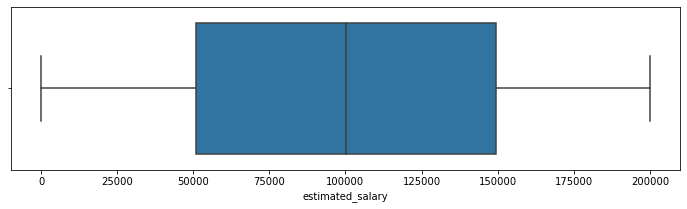

In [14]:
# Reviewing estimated salary distribution
print('Estimated Salary Distribution')
plt.figure(figsize=(12, 3))
fig = sns.boxplot(data=df, x="estimated_salary")


Median estimated salary is around 100 thousand RUR, 50% of bank clients have estimated salary between 50 and 150 thousand RUR.

In [15]:
# Reviewing values for number of real estate objects
df['objects'].unique()

array([ 2,  1,  8,  7,  4,  6,  3, 10,  5,  9,  0], dtype=int64)

The number of real estate objects owned by the bank clients varies from 0 to 10. These values are possible.

In [16]:
# Calculating the total number of missing values
print('Number of missing values:')
print(df['balance'].isna().sum())

Number of missing values:
3617


In [17]:
# Creating a separate column for data on missing values
df['missing'] = df['balance'].isna()

# Analyzing distribution of missing values on account balance using various factors
# Counting missing values by city
df.groupby('city')['missing'].sum()

city
Ростов Великий       0
Рыбинск           1199
Ярославль         2418
Name: missing, dtype: int64

Missing data on client account balance is present in the data on the bank clients from Rybinsk and Yaroslavl. There is no missing data on bank clients from Rostov the Great.

In [18]:
# Analyzing, how large are the gaps relevant to total number of clients by cities 
df.groupby('city')['userid'].count()

city
Ростов Великий    2509
Рыбинск           2477
Ярославль         5014
Name: userid, dtype: int64

Both in Rybinsk and Yaroslavl the data on account balance is missing for a considerable number of clients (about a half).

In [19]:
# Analyzing the missing data by the fact of churn 
df.groupby('churn')['missing'].sum()

churn
0    3117
1     500
Name: missing, dtype: int64

Noteworthy, most missing data is related to the active clients who have not churned. There are also some gaps in the data on churned clients.

In [20]:
# Analyzing the missing data by client loyalty rating 
df.groupby('loyalty')['missing'].sum()

loyalty
0    1744
1    1873
Name: missing, dtype: int64

Some data on account balance is missing both among the loyal bank clients and among the clients not considered loyal. 

In [21]:
# Analyzing the missing data depending on the quantity of bank products used by the client
df.groupby('products')['missing'].sum()

products
1     905
2    2600
3      98
4      14
Name: missing, dtype: int64

Gaps in data do not depend on the number of bank products used: even for some clients using 4 bank products the data on account balance is missing.

In [22]:
# Analyzing the missing data depending on the use of credit card by the client
df.groupby('credit_card')['missing'].sum()

credit_card
0    1025
1    2592
Name: missing, dtype: int64

Some data is missing both among the clients using credit cards and among the clients who do not use this instrument.


In [23]:
# Analyzing credit score column
print('minimum score', df['score'].min())
print('median score', df['score'].median())
print('maximum score', df['score'].max())

minimum score 350
median score 652.0
maximum score 850


In [24]:
# Defining groups of clients depending on credit score 

def score_group(score):
    """
    Returns credit score group using the following rules:
    - 'low credit score', if score <= 550;
    - 'medium credit score', if score from 550 to 750;
    - 'high credit score' — higher than 750.
    """
    
    if score <= 550:
        return 'low'
    if score <= 750:
        return 'medium'
    return 'high'

df['score_group'] = df['score'].apply(score_group)
print(df['score_group'].value_counts()) 

medium    6781
low       1621
high      1598
Name: score_group, dtype: int64


In [25]:
# Analyzing the distribution of missing data depending on credit score group 
df.groupby('score_group')['missing'].sum()

score_group
high       552
low        593
medium    2472
Name: missing, dtype: int64

Missing data is present among the clients with credit scores from all credit score groups.

Distribution of Missing Data on Account Balance by Client Age


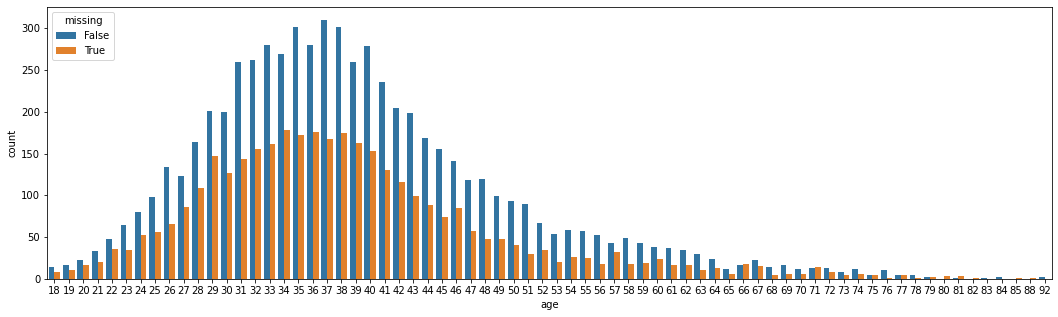

In [26]:
# Analyzing the distribution of missing data by client age
print('Distribution of Missing Data on Account Balance by Client Age')
plt.figure(figsize=(18, 5))
sns.countplot(data=df, x="age", hue="missing")
plt.show()

In [27]:
#For the purposes of further analysis let us define age groups for bank clients 

def age_group(age):
    """
    The function returns age group depending on client age:
    - 'youth', if age <= 29 years;
    - 'middle age', if age between 30 and 45;
    - 'over middle age', if age between 45 and 60;
    - 'pension age', if age is higher than 60
    """
    
    if age <= 29:
        return 'youth'
    if age <= 45:
        return 'middle age'
    if age <= 60:
        return 'over middle age'
    return 'pension age'

df['age_group'] = df['age'].apply(age_group)
print(df['age_group'].value_counts()) 

middle age         6248
over middle age    1647
youth              1641
pension age         464
Name: age_group, dtype: int64


In [28]:
#Analyzing missing data by age groups

df.groupby('age_group')['missing'].sum()

age_group
middle age         2281
over middle age     526
pension age         167
youth               643
Name: missing, dtype: int64

Missing data on client balance does not depend on their age groups.

In [29]:
#For further analysis let us define client income groups based on estimated salary

def income_group(income):
    """
    Returns client income group depending on their estimated salary:
    - 'low', if estimated_salary <= 50000;
    - 'low middle', if estimated_salary between 50000 and 100000;
    - 'high middle', if estimated_salary between 100000 and 150000;
    - 'high', if estimated_salary higher than 150000
    """
    
    if income <= 50000:
        return 'low'
    if income <= 100000:
        return 'low middle'
    if income <= 150000:
        return 'high middle'
    return 'high'

df['income_group'] = df['estimated_salary'].apply(income_group)
print(df['income_group'].value_counts()) 

high middle    2555
low middle     2537
high           2455
low            2453
Name: income_group, dtype: int64


In [30]:
#Analyzing missing data by on income groups 

df.groupby('income_group')['missing'].sum()

income_group
high           873
high middle    908
low            915
low middle     921
Name: missing, dtype: int64

Some data is missed both for the clients with low estimated salary and clients assigned to high income group. 

Correlation between the Account Balance and Estimated Salary


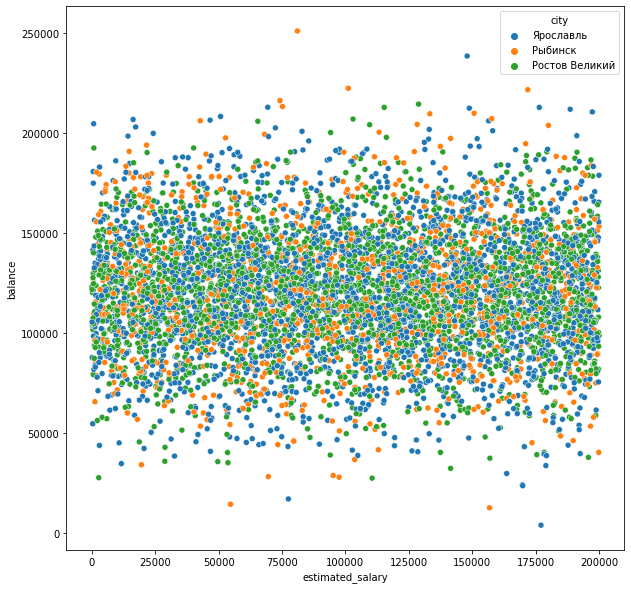

In [31]:
# Analyzing whether there is correlation between the account balance and estimated salary 

print('Correlation between the Account Balance and Estimated Salary')
plt.figure(figsize=(10, 10))
fig = sns.scatterplot(data=df, x="estimated_salary", y="balance", hue="city")
plt.show()

There is no correlation between the estimated salary and client's outstanding balance.

Correlation between Client Age and Account Balance


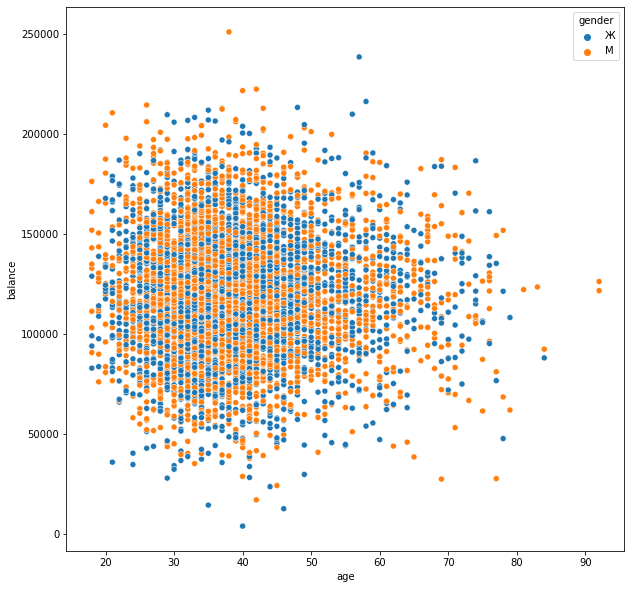

In [32]:
# Analyzing the correlation between client age and outstanding balance (with gender used as a hue)

print('Correlation between Client Age and Account Balance')
plt.figure(figsize=(10, 10))
fig = sns.scatterplot(data=df, x="age", y="balance", hue="gender")
plt.show()

There is no correlation between client age and account balance either.

Correlation between Credit Score and Account Balance


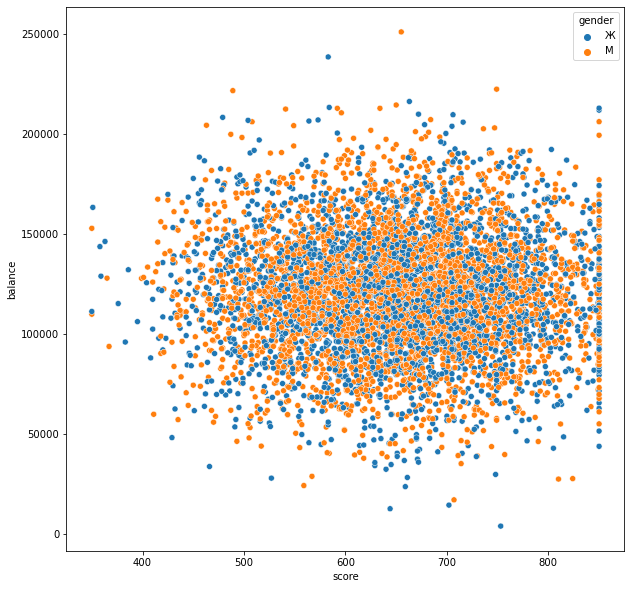

In [33]:
# Analyzing the correlation between credit score and outstanding balance (with gender used as a hue)

print('Correlation between Credit Score and Account Balance')
plt.figure(figsize=(10, 10))
fig = sns.scatterplot(data=df, x="score", y="balance", hue="gender")
plt.show()

There is no correlation between credit score and account balance. 

**Interim conclusion**

*Overall*, the gap analysis has demonstrated that some data on account balance is missed for clients from 2 out of 3 branches of the bank (branches in Yaroslavl and Rybinsk). The fact of missing data does not depend on client churn, loyalty, number of bank products used, use of credit card, age, estimated salary or credit score

Possibly the data on account balance has been added to the database in Yaroslavl and Rybinsk recently, hence, for some clients this data is missing.

Estimated salary, client age and credit rating do not correlate with client account balance. Hense, these variable cannot be used for filling in the gaps. Missing data on account balance accounts for considerable portion of the total dataset; excluding these clients for further research may lead to incorrect conclusions. 

Therefore it is suggested:
- to use initial dataset for analyzing all factors, except for account balance, 
- exclude missing data for analyzing balance factor. 

## 3 Exploratory Data Analysis

This phase of the project includes:

- analysis of factor distribution for the entire dataset
- correlation analysis.

In [34]:
# Defining a function for distribution graphs 

def hist_graph(data, parameter, hue, title, title_parameter):
    """
    Returns a countplot for the defined parameter in dataset  
    demonstrating differences based on hue.
    """
    sns.set_palette('pastel')
    plt.figure(figsize=(12, 5))
    ax = sns.countplot(data=data, x=parameter, hue=hue)
    ax.set_title(title)
    ax.set_xlabel(title_parameter)
    ax.set_ylabel('Number of clients')
    return plt.show()



In [35]:
# Defining a function for returning a boxplot 

def boxplot_graph(data, parameter, group, hue, title, title_parameter, title_group):
    """
    Returns a boxplot demonstrating distribution of 'parameter' value in the dataset  
    grouped by 'group' with differences by 'hue'.
    """
    sns.set_palette('pastel')
    plt.figure(figsize=(14, 8))
    ax = sns.boxplot(data=data, x=parameter, y=group, hue=hue)
    ax.set_title(title)
    ax.set_xlabel(title_parameter)
    ax.set_ylabel(title_group)
    return plt.show()


In [36]:
# Defining a function returning key dataset statistics for a given parameter 

def key_stat(parameter, parameter_title):
    """
    Returns key statistics for a given parameter.
    """
    return print(parameter_title, 
           'maximum value:', parameter.max(),
           'minimum value:', parameter.min(),
           'median value:', parameter.median(),
           'mean value:', parameter.mean()
                )


Distribution by age maximum value: 92 minimum value: 18 median value: 37.0 mean value: 38.9218


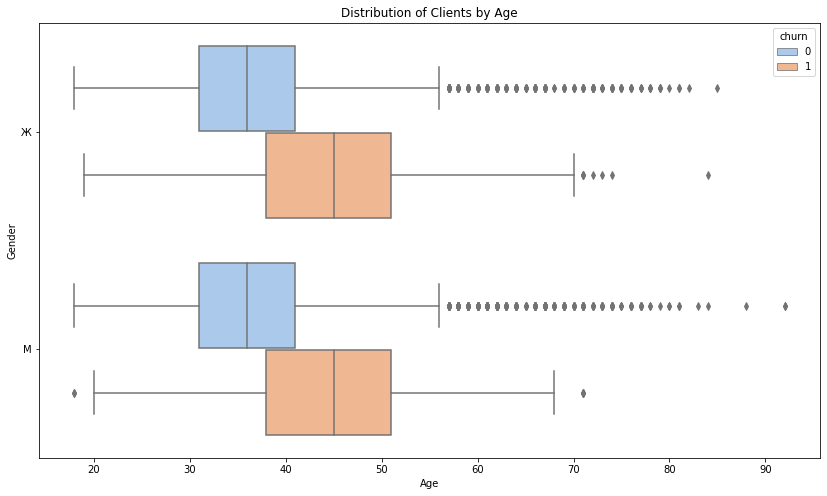

In [37]:
# Using the functions above let us analyze social and demographic characteristics of the dataset

key_stat(df['age'], 'Distribution by age')
boxplot_graph(df,"age", "gender", "churn", 'Distribution of Clients by Age', 'Age','Gender')


Overall, the age of bank clients varies from 18 to 92. Median client age is 37. There are substantial differences among retained clients and churned clients: median age of churned clients is 45 years old; half of the clients that left the bank were between 38 and 52 years old. This trend is true both for men and women. 

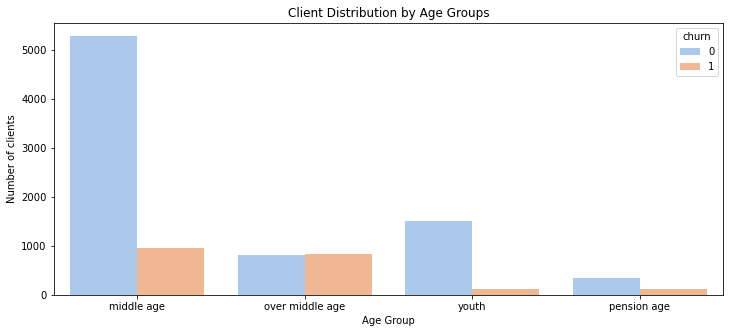

In [38]:
# Analyzing the distribution of retained and churned clients by age groups 

hist_graph(df, "age_group", "churn", 'Client Distribution by Age Groups', 'Age Group') 

The highest churn rate is in the 'over middle age' group (between 45 and 60 years old). In this group the number of churned clients is higher than the number of retained clients.

Significant churn rate is also seen among the bank clients of pension age and among middle age group (since most clients of the bank are in middle age group, i.e. between 30 and 45 years old, in absolute terms the maximum number of churned clients is in this group).

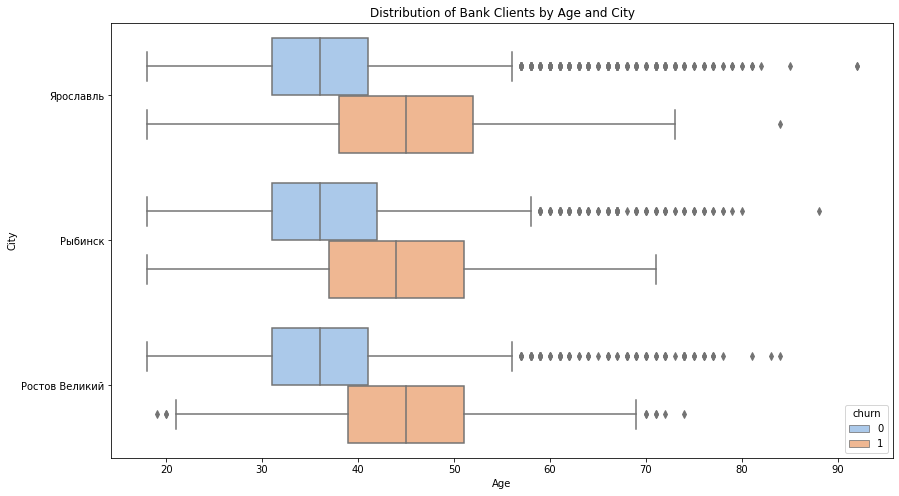

In [39]:
# Analysing bank clients by age and city

boxplot_graph(df,"age", "city", "churn", 'Distribution of Bank Clients by Age and City', 'Age','City')

The trend of higher churn rate among more senior clients is relevant for all cities included in the dataset. In Yaroslavl and Rostov the Great the median age of churned clients is slightly higher than in Rybinsk.

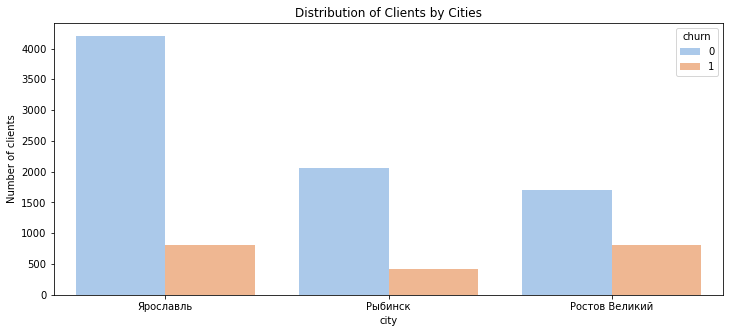

In [40]:
# Analyzing distribution of churned and retained clients by cities

hist_graph(df, "city", "churn", 'Distribution of Clients by Cities', 'city') 

In [41]:
# Getting numeric statistics by cities

df.groupby(['city','churn'])['userid'].count()

city            churn
Ростов Великий  0        1695
                1         814
Рыбинск         0        2064
                1         413
Ярославль       0        4204
                1         810
Name: userid, dtype: int64

The highest churn rate in relative and absolute terms is seen in Rostov the Great: 814 clients in this city (or about a third of total number of clients) have left the bank in this city. Significant client churn is also seen in Yaroslavl (810 clients). In relative terms, the situation in Yaroslavl and Rybinsk is similar.

In [42]:
# Analyzing distribution of churn and retained clients depending on their credit score

key_stat(df['score'], 'Credit score')

Credit score maximum value: 850 minimum value: 350 median value: 652.0 mean value: 650.5288


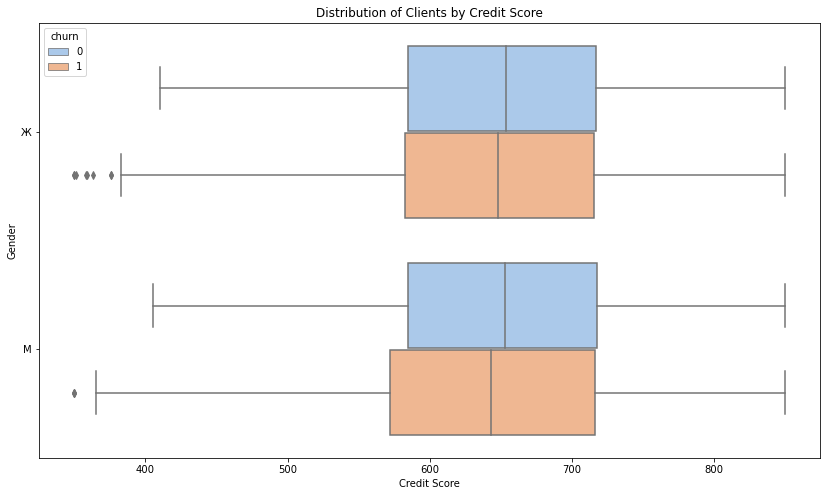

In [43]:
# Analyzing distribution of churn and retained clients depending on their credit score and gender

boxplot_graph(df,"score", "gender", "churn", 'Distribution of Clients by Credit Score', 'Credit Score', 'Gender')

In [44]:
# Getting numeric statistics by credit score

df.groupby('churn')['score'].median()

churn
0    653.0
1    646.0
Name: score, dtype: float64

Bank clients have credit score varying from 350 to 850 points. Median credit score is 652 points. Noteworthy, credit score among churned clients is slightly lower than among the clients retained by the bank (median credit score among the churned clients accounts for 646 points and median score among retained clients reaches 653 points).

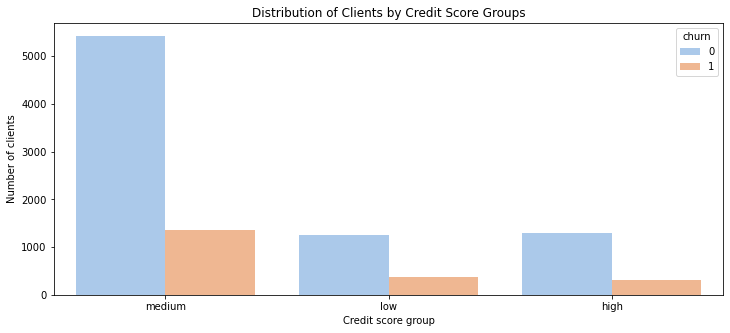

In [45]:
#Analyzing bank clients by credit score groups

hist_graph(df, "score_group", "churn", 'Distribution of Clients by Credit Score Groups', 'Credit score group') 

Noteworthy, most of the churned clients had medium credit score rating (between 550 and 750 points). There is also some churn among the clients with low credit score (below 550 points) and high credit score (above 750 points).

Estimated salary maximum value: 199992.48 minimum value: 11.58 median value: 100193.915 mean value: 100090.2398809998


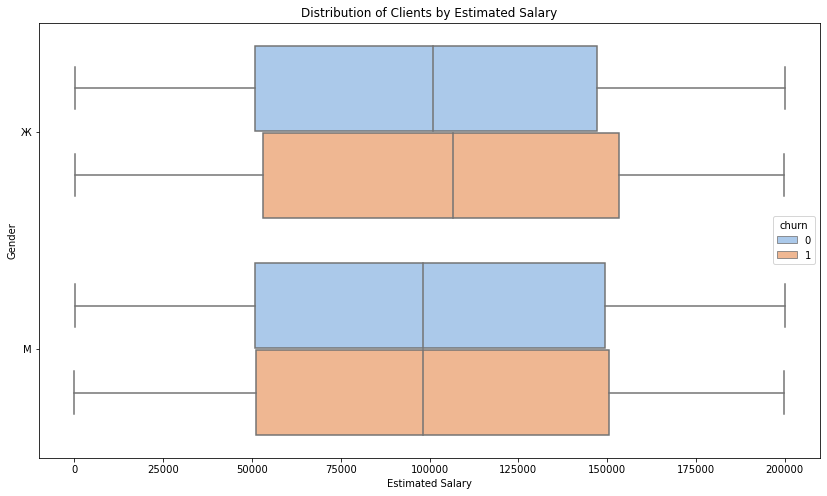

In [46]:
# Analyzing distribution of bank clients by estimated salary

key_stat(df['estimated_salary'], 'Estimated salary')
boxplot_graph(
    df,"estimated_salary", "gender", "churn", 'Distribution of Clients by Estimated Salary', 'Estimated Salary', 'Gender'
)

In [47]:
# Getting median estimated salary statistics

df.groupby('churn')['estimated_salary'].median()

churn
0     99645.04
1    102460.84
Name: estimated_salary, dtype: float64

Median estimated salary of bank clients included into the dataset accounts for some 100193,9 RUR/month. Median estimated salary among the churned clients is slightly higher (102460.84 RUR), than among the remained clients (99645,04 RUR). Noteworthy, that differences in estimated salary among the churned and retained clients are relevant only for female clients. 

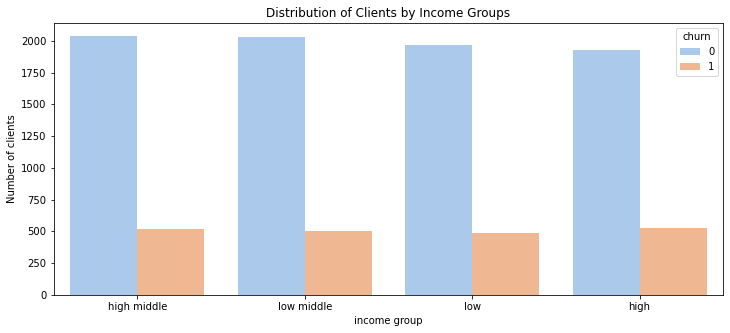

In [48]:
# Analyzing distribution of clients by estimated income groups

hist_graph(df, "income_group", "churn", 'Distribution of Clients by Income Groups', 'income group') 

The graph above demonstrates that churn of clients is present in all groups irrespective of salary estimates. In relative terms a slightly higher churn is noted among the clients with high estimated salary.

Number of real estate objects maximum value: 10 minimum value: 0 median value: 5.0 mean value: 5.0128


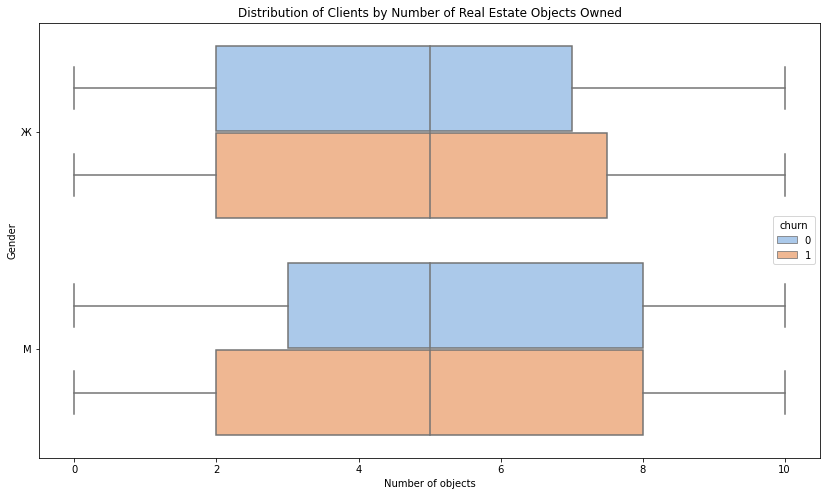

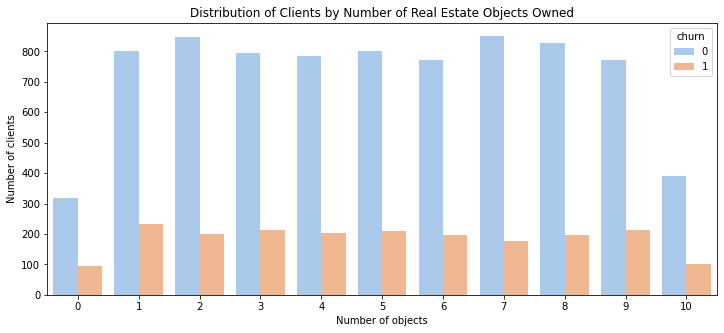

In [49]:
# Analyzing the bank clients distribution by the number of real estate objects owned

key_stat(df['objects'], 'Number of real estate objects')

boxplot_graph(
    df,"objects", "gender", "churn", 
    'Distribution of Clients by Number of Real Estate Objects Owned', 'Number of objects', 'Gender'
)
hist_graph(df, "objects", "churn", 'Distribution of Clients by Number of Real Estate Objects Owned', 'Number of objects') 

On average, bank clients own 5 real estate objects (which is quite high). This indicator does not vary significantly among the clients that left the bank and those retained by the bank. 

Number of bank products used: maximum value: 4 minimum value: 1 median value: 1.0 mean value: 1.5302


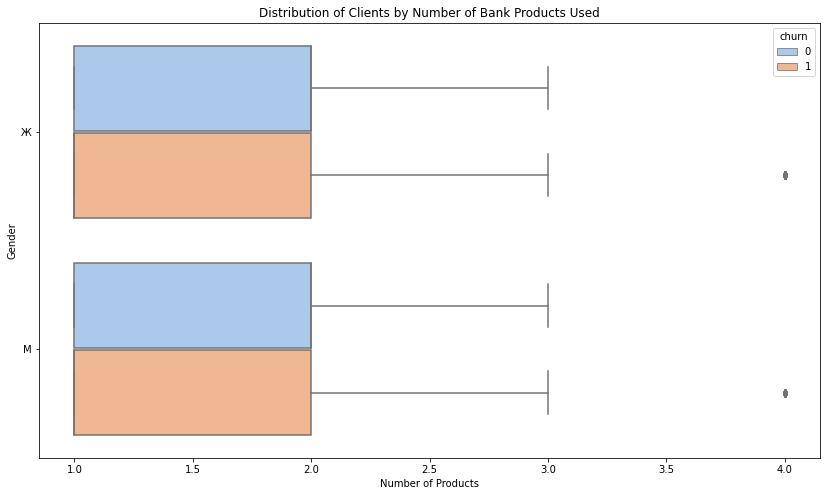

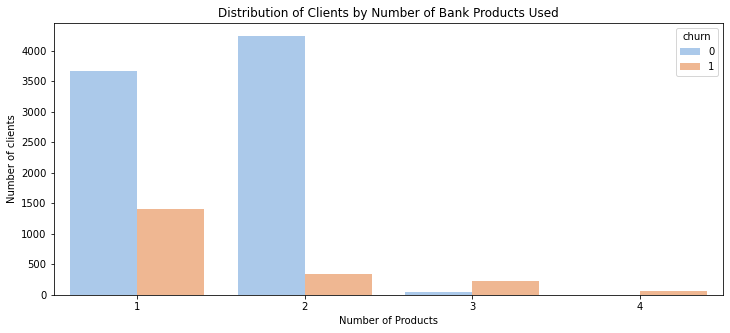

In [50]:
# Analyzing the distribution of clients by the number of bank products used

key_stat(df['products'], 'Number of bank products used:')
boxplot_graph(
    df,"products", "gender", "churn", 'Distribution of Clients by Number of Bank Products Used', 'Number of Products', 'Gender'
)

hist_graph(df, "products", "churn", 'Distribution of Clients by Number of Bank Products Used', 'Number of Products') 

In [51]:
#Counting numeric data
prod = df.groupby('products')['userid'].count().reset_index()
print(prod)

   products  userid
0         1    5084
1         2    4590
2         3     266
3         4      60


In [52]:
# Distrobution of clients by consumption (number of bank products used)

fig = go.Figure(data=[go.Pie(labels=prod['products'], 
                             values=prod['userid'], 
                             pull = [0.1, 0])]) 
fig.update_layout(title='Distrobution of Bank Clients by Number of Bank Products Used', 
                  width=800, 
                  height=600,
                  annotations=[dict(x=1.12, 
                                    y=1.05,
                                    text='Number of products',
                                    showarrow=False)])
fig.show() 


Bank clients use from 1 to 4 products. Median number of products used both by the retained clients and by the clients that left the bank is 1. This meand that over a half of bank clients use only one bank product.
90% of bank clients use 2 bank products and less. Only some churned clients used 4 bank products (60 clients out of 10K dataset).

Such uneven distribution of clients suggests that during the client segmentation it is expedient to unite clients using 3 and 4 products into one group.

In relative terms the highest churning rate is seen among the clients that used 3 or 4 bank products. The lowest churning rate is among the clients that used only 2 products. 

Credit Card Use maximum value: 1 minimum value: 0 median value: 1.0 mean value: 0.7055


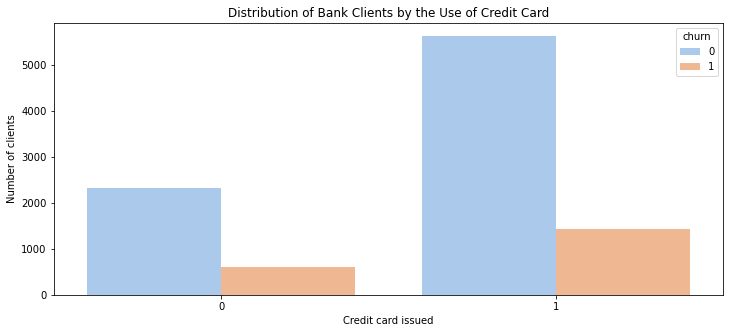

In [53]:
# Analyzing the distribution of clients by the use of credit card

key_stat(df['credit_card'], 'Credit Card Use')

hist_graph(df, "credit_card", "churn", 'Distribution of Bank Clients by the Use of Credit Card', 'Credit card issued') 

In [54]:
# Getting numeric statistics for distribution of churned and retained clients by credit card

df.groupby(['churn', 'credit_card'])['userid'].count()

churn  credit_card
0      0              2332
       1              5631
1      0               613
       1              1424
Name: userid, dtype: int64

Some 70,55% bank clients use credit cards. Churn from the bank is seen both among the clients that use credit cards and among those who do not use this instrument.

Loyalty indicator. maximum value: 1 minimum value: 0 median value: 1.0 mean value: 0.5151


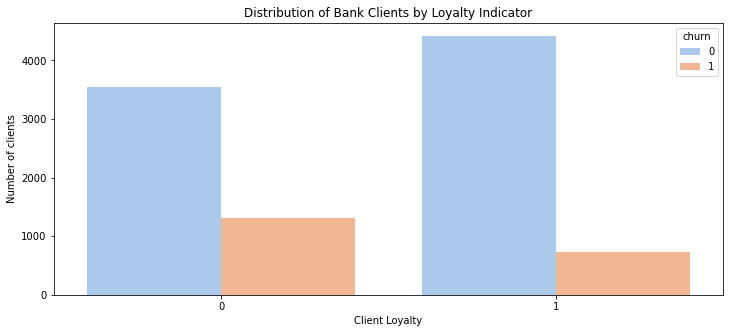

In [55]:
# Analyzing distribution of bank clients by loyalty to the bank 

key_stat(df['loyalty'], 'Loyalty indicator.')

hist_graph(df, "loyalty", "churn", 'Distribution of Bank Clients by Loyalty Indicator', 'Client Loyalty') 

Overall some 51.51% of bank clients in the dataset are rated as loyal. It is logical that the share of loyal clients is higher among the retained clients group compared to the group that left the bank.

Account Balance. maximum value: 250898.09 minimum value: 3768.69 median value: 119839.69 mean value: 119827.49379288674


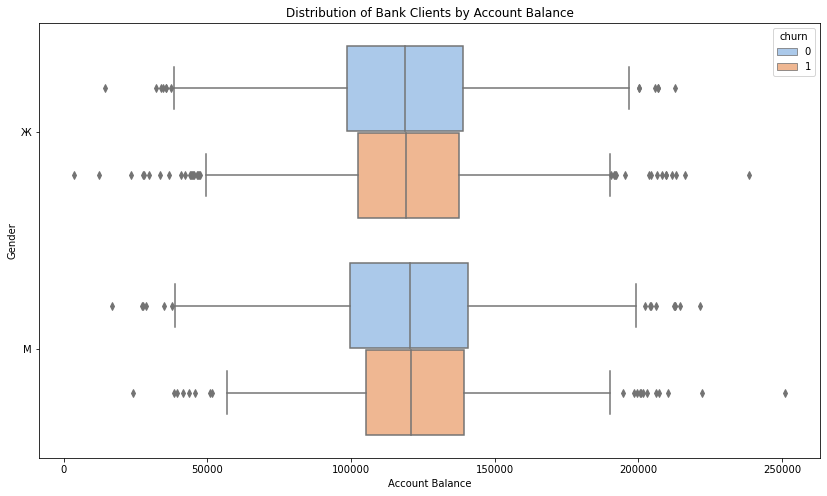

In [56]:
# Analyzing Distribution of Bank Clients by Account Balance

key_stat(df['balance'], 'Account Balance.')
boxplot_graph(df,"balance", "gender", "churn", 'Distribution of Bank Clients by Account Balance', 'Account Balance', 'Gender')


Outstanding balance of the account varies from 3.8 to 250.9K RUR. Mean account balance accounts for 119.8K RUR and does not differ much depending on whether a client was retained or left the bank. Men tend to have a slightly higher outstanding balance than women.

In [57]:
# Creating a dummy variable to account for cities in correlation analysis 

city_dummy=pd.get_dummies(data=df['city'])

df['rostov_d'] = city_dummy['Ростов Великий']
df['rybinsk_d'] = city_dummy['Рыбинск']
df['yaroslavl_d'] = city_dummy['Ярославль']


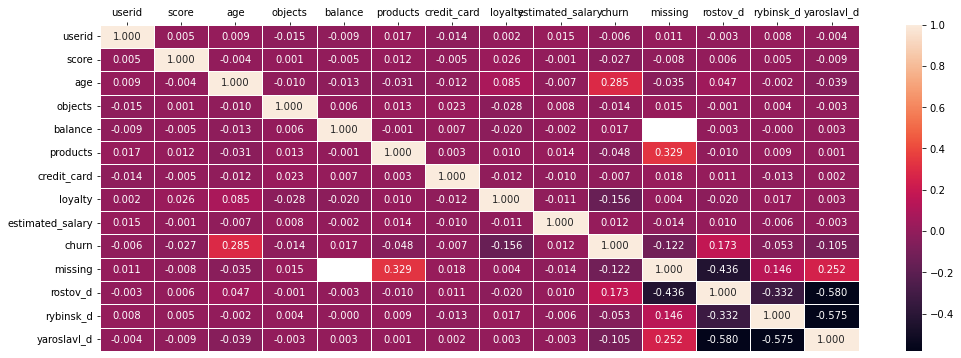

In [58]:
# Computing a correlation matrix 

plt.figure(figsize=(17,6))
ax = sns.heatmap(data=df.corr(), annot=True, linewidth=.5, fmt=".3f")
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()

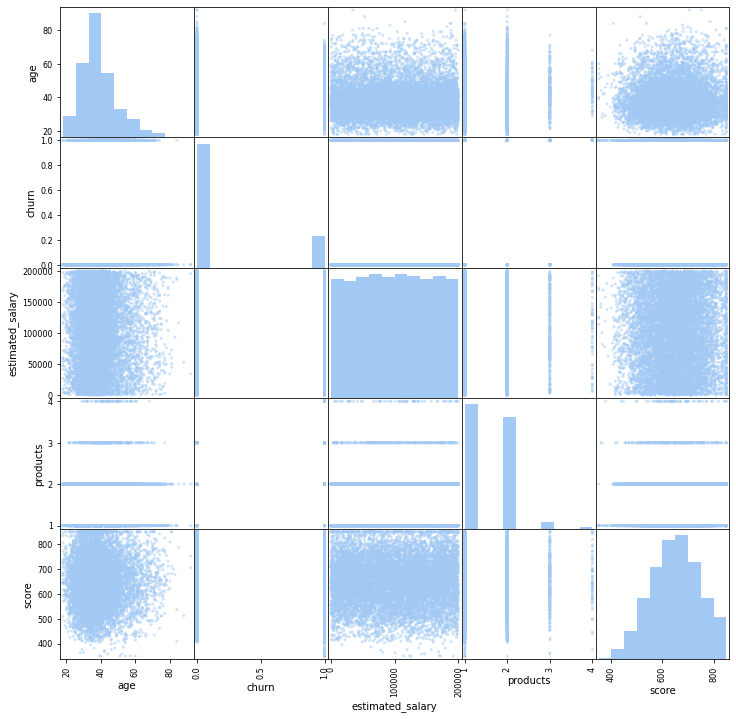

In [59]:
# Visualizing pair correlations

df_corr = df.pivot_table(index='userid',values=['age','estimated_salary', 'score', 'products', 'churn'], aggfunc='mean')
pd.plotting.scatter_matrix(df_corr, figsize=(12,12))
plt.show()

Correlation analysis suggests that most factors included in the analysis are not correlated with the churn risk. The only factor which demonstates some weak correlation with client churn is client age (correlation coefficient is 0.285 which demonstrates weak positive correlation between the client age and churn risk).

**Interim Conclusions**

At the stage of exploratary analysis the data on 10,000 bank clients was analyzed. 

Overall, the age of bank clients varies from 18 to 92. Median client age is 37. There are substantial differences among retained clients and churned clients: median age of churned clients is 45 years old; half of the clients that left the bank were between 38 and 52 years old. This trend is true both for men and women. 

The highest churn rate is in the 'over middle age' group (between 45 and 60 years old). In this group the number of churned clients is higher than the number of retained clients.

Weak correlation between client age and churn risk is confirmed by the results of correlation analysis: correlation coefficient between these factors is 0.285 which demonstrates weak positive correlation between the client age and churn risk.

The highest churn rate in relative and absolute terms is seen in Rostov the Great: 814 clients in this city (or about a third of total number of clients) have left the bank in this city. Significant client churn is also seen in Yaroslavl (810 clients). In relative terms, the situation in Yaroslavl and Rybinsk is similar.

Bank clients have credit score varying from 350 to 850 points. Median credit score is 652 points. Noteworthy, credit score among churned clients is slightly lower than among the clients retained by the bank (median credit score among the churned clients accounts for 646 points and median score among retained clients reaches 653 points).

Median estimated salary of bank clients included into the dataset accounts for some 100193,9 RUR/month. Median estimated salary among the churned clients is slightly higher (102460.84 RUR), than among the remained clients (99645,04 RUR). Noteworthy, that differences in estimated salary among the churned and retained clients are relevant only for female clients. 

Churn of clients is present in all groups irrespective of salary estimates. In relative terms a slightly higher churn is noted among the clients with high estimated salary.

Bank clients use from 1 to 4 products. Median number of products used both by the retained clients and by the clients that left the bank is 1. This meand that over a half of bank clients use only one bank product.
90% of bank clients use 2 bank products and less. Only some churned clients used 4 bank products (60 clients out of 10K dataset).

Such uneven distribution of clients suggests that during the client segmentation it is expedient to unite clients using 3 and 4 products into one group.

In relative terms the highest churning rate is seen among the clients that used 3 or 4 bank products. The lowest churning rate is among the clients that used only 2 products. 


## 4 Segmenting Bank Clients

At this stage of the project the analysis of client segments will be conducted. 

Based on the above analysis it is expedient to segment bank clients based on 2 factors:

- number of bank products used (1, 2 and more)
- client age group (youth, middle age, over middle age, pensioniers) 

In [60]:
# Defining client groups based on the number of products used

def product_group(products):
    """
    The function returns a client group depending on the number of bank products used:
    - 'one product', if products = 1;
    - 'two products', if products = 2;
    - 'more than two products', if products > 2
    """
    
    if products == 1:
        return 'one product'
    if products == 2:
        return 'two products'
    return 'more than two products'

df['product_group'] = df['products'].apply(product_group)
print(df['product_group'].value_counts()) 

one product               5084
two products              4590
more than two products     326
Name: product_group, dtype: int64


In [61]:
# Analyzing bank clients segmentation based on the number of bank products used only 

df_segm1 = df.pivot_table(index='product_group', aggfunc='mean')

display(df_segm1)

age        balance     churn  credit_card  \
product_group                                                             
more than two products  43.653374  120074.314953  0.858896     0.708589   
one product             39.673092  119894.163723  0.277144     0.703777   
two products            37.753595  119660.944362  0.075817     0.707190   

                        estimated_salary   loyalty   missing   objects  \
product_group                                                            
more than two products     104400.141503  0.435583  0.343558  5.058282   
one product                 99487.256851  0.504131  0.178009  4.974626   
two products               100452.012821  0.532898  0.566449  5.051852   

                        products  rostov_d  rybinsk_d       score  \
product_group                                                       
more than two products  3.184049  0.368098   0.223926  649.113497   
one product             1.000000  0.265342   0.240165  649.120968   
two products            2.000000  0.226580   0.257734  652.188671   

                              userid  yaroslavl_d  
product_group                                      
more than two products  1.573768e+07     0.407975  
one product             1.573237e+07     0.494493  
two products            1.573484e+07     0.515686

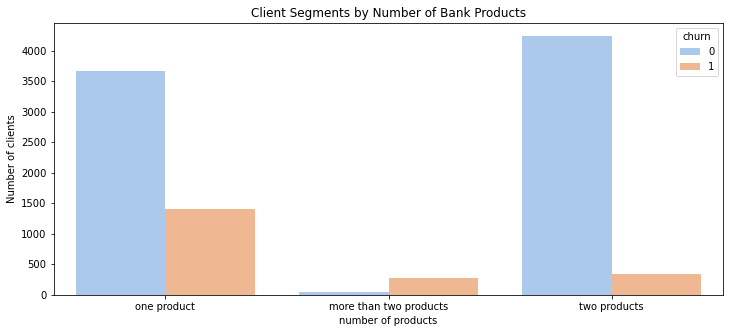

In [62]:
#Visualizing client segments by number of bank products

hist_graph(df, "product_group", "churn", 'Client Segments by Number of Bank Products', 'number of products') 

Segmenting bank clients based on the number of bank products used resulted in three groups of clients:

*Clients using 1 bank product* - the largest client group (50.84% of total dataset). Average client age in this group is 39,67 years, average credit score is 649.12 points, average estimated salary is 99.5K RUR, 50.4% clients in this group are rated as loyal, churn rate accounted for 27,7%.

*Clients using 2 bank products* - the second largest group of bank clients (45.9%). Average client age in this group is 37,7 years, average credit score accounts for 652.2 points, mean estimated salary is 100.5K RUR, 53.3% of clients in this group are rated as loyal. This group is characterized by the lowest churn rate (7.6%).

*Clients using 3 or 4 bank products* - the smallest group of bank clients (3.3% of total dataset) which demonstrates the highest churn rate (85.9% of clients in this group left the bank). Average client age is 43,7 years, average credit score 649,1 points, 43.5% of clients in this group were rated as loyal, mean estimated salary accounted for 104,4K RUR.

In [63]:
# Defining additional segments of clients using one or two bank projects by age groups

df_segm2 = df.loc[df['product_group'] !='more than two products']
df_segm3 = df_segm2.pivot_table(index=['product_group', 'age_group'], aggfunc='mean').reset_index()

display(df_segm3)
df_segm4 = df_segm2.pivot_table(index=['product_group', 'age_group'], values='userid', aggfunc='count')
display(df_segm4)



product_group        age_group        age        balance     churn  \
0   one product       middle age  37.067099  119344.086530  0.209400   
1   one product  over middle age  51.332663  120703.938716  0.609045   
2   one product      pension age  67.257028  117564.603971  0.301205   
3   one product            youth  25.858278  121836.251664  0.108609   
4  two products       middle age  36.753676  119711.496523  0.056818   
5  two products  over middle age  50.981584  118780.034474  0.235727   
6  two products      pension age  68.010204  121606.160000  0.127551   
7  two products            youth  25.970896  119698.584575  0.029104   

   credit_card  estimated_salary   loyalty   missing   objects  products  \
0     0.702431     100444.196039  0.486872  0.172447  4.958509         1   
1     0.701508      98200.332000  0.473367  0.217085  4.971859         1   
2     0.686747      93078.887992  0.775100  0.180723  5.068273         1   
3     0.717881      99386.616689  0.525828  0.148344  5.013245         1   
4     0.706551      99676.222590  0.503008  0.564505  5.043449         2   
5     0.697974     101502.245912  0.626151  0.510129  5.046041         2   
6     0.739796     103462.724031  0.882653  0.591837  4.637755         2   
7     0.707800     101803.338091  0.498254  0.603027  5.179278         2   

   rostov_d  rybinsk_d       score        userid  yaroslavl_d  
0  0.246677   0.245381  649.585089  1.573221e+07     0.507942  
1  0.330653   0.226131  646.864322  1.573575e+07     0.443216  
2  0.265060   0.269076  650.076305  1.572626e+07     0.465863  
3  0.255629   0.227815  649.883444  1.573055e+07     0.516556  
4  0.231618   0.254345  652.443182  1.573497e+07     0.514037  
5  0.248619   0.276243  647.029466  1.573437e+07     0.475138  
6  0.209184   0.260204  659.923469  1.574098e+07     0.530612  
7  0.199069   0.257276  652.798603  1.573328e+07     0.543655

userid
product_group age_group              
one product   middle age         3085
              over middle age     995
              pension age         249
              youth               755
two products  middle age         2992
              over middle age     543
              pension age         196
              youth               859

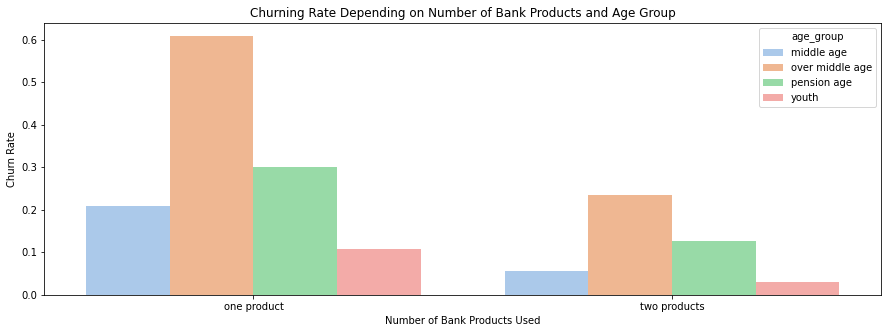

In [64]:
# Vizualizing churn rate among the client segments defined by number of bank products used and client age

plt.figure(figsize=(15,5))
ax=sns.barplot(data=df_segm3, x="product_group", y="churn", hue="age_group")
ax.set_title('Churning Rate Depending on Number of Bank Products and Age Group')
ax.set_xlabel('Number of Bank Products Used')
ax.set_ylabel('Churn Rate')
plt.show()

Further segmentation of the clients using 1 bank product by age groups demonstrates that churn rate in this group changes depending on client age.

Minimal churn rate among the clients using one product is seen among young clients (aged up to 29) - 10.9%. This group is also characterized by the highest ratio of loyal clients (77.5% of clients in this group are rated loyal).

The churn rate among the clients of middle age is higher (20.9%). Less than a half (48.6%) of clients in this segment are rated loyal. However, the highest churn rate among the clients using one product is seen among the clients aged 45 to 60: 60.9% of such clients have left the bank. Noteworthy, the average credit score in this group is also slightly lower (646.86 points). There is notable churn rate among pension age clients using one bank product: some 30.1% of such clients have left the bank.

The analysis of the bank clients using 2 bank products grouped by age also demoinstrates the highest churn rate in the 'over middle age' group. However the churn rate in this group is much lower than among similar age group of clients using only 1 bank product (23.6%). The churn rate among pension age clients using 2 bank products accounted for 12.8% and did not exceed 6% for other age groups of clients using 2 bank products.


**Interim Conclusions**

Based on the segmentation results, the following bank client groups were defined (by the urgency of addressing client churn issue):

1. *Group requiring immediate attention* includes clients using 3-4 bank products. The group is characterized by the highest churn rate (85.9%) while the group itself is not very large (3.3% of total dataset). Average client age in this group is 43.7 years old, average credit score is 649.1 points, some 43,5% of group clients are rated as loyal, average salary estimate accounts for 104,4K RUR. 

It is likely that the high churn rate in this group is related to more attractive products and loyalty programs proposed by competitors. It is recommended to develop a special loyalty program for the clients using more than 2 bank products. 

2. *Group requiring high attention* includes bank clients aged 45 to 60 that use only one bank product. The churn rate in this group accounts for 60.9%. The group is characterized by slightly lower level of average credit score (646.86 points). The group accounts for some 10 percent bank clients.

It is likely that high churn rate in this group is related to the absence of attractive bank projects for the age category in question. It is recommended to consider a possibility for developing special products for clients aged 45+, including credit instruments. 

3. *Groups requiring attention* include client segments with churn rates ranging from 10% to 30.1% (overall these segments account for some 48.2% of the bank clients included into the dataset). The groups requiring attention include:

- *Loyal mature clients* - clients aged between 45 and 60 using 2 bank products. The churn rate in this group accounts for some 23.6%, loyalty rate is 62.6%, average credit rating is 647 points. The churn rate in this group is the highest among the clients using 2 bank products. Retaining such clients may be supported by special products (including credit products) for clients aged 45+. 

- *Loyal pensioniers* - clients in pension age using 2 bank products. Churn rate in this group accounts for 12.8% (lower than average in the bank), loyalty rate is 88.2%, average account balance is 121.6K RUR. To reduce churn rate in this group introduction of special products for pensioniers may be considered.

- *Relatively loyal clients aged below 45* - clients younger than 45 years old using 1 bank product. The churn rate in this group is 20.9% for middle age clients and 10.8% for young clients. Average credit rating accounts for 649 points. Retaining this clients would call for developing a loyalty program: the analysis demonstrates that clients using 2 bank products tend to be retained more frequently.

- *Pensioniers at-rist* - clients of 60+ age using one bank product. The churn rate in the group reaches 30.1%, loyalty rate is 77.5%, average account balance is 117.6K RUR. To retain these clients, it is recommended to consider special bank products oriented at pensioniers. These programs are especially relevant given that some large banks have introduced bonus programs for transferring pensions.

4. *Most loyal group* - includes clients younger than 45 years old using 2 bank products. The group accounts for 38.5% of total bank clients. The churn rate in the group does not exceed 6%. Average credit score is 652 points, average balance account equals  99.7K RUR, the share of clients rated as loyal is about 50%.

The results of bank segmentation also suggests that there might be a need to revise the internal definition of 'loyal' clients (i.e. review the conditions of rating a certain client as loyal). As demonstrated by the above analysis, a high share of loyal segments (as rated internally) does not necessarily translate into lower churn rates and vice versa.

## 5 Statistical Research

The objective of this stage is to formulate and check hypotheses revealing the reasons for clients to leave the bank or factors that influence retain rate. 

Firstly, there is a need to check a hypothesis on difference of income among the clients using two bank products and those using only one bank product. 

To perform a statistical test, let us formulate a zero hypothesis and an alternative hypothesis:

Zero hypothesis: average estimated salary of clients using two bank products is equal to average estimated salary of clients using one bank product.
Alternative hypothesis: average estimated salary of clients using two bank products is different from average estimated salary of clients using one bank product.

To compare average estimated salary we will use t-test. Since the number of clients in the two groups is different, we will assume that dispersions of the samples are not equal. 

In [65]:
# sample 1 - estimated salary of clients, using 1 bank product
sample_1 = df.loc[df['products']==1]['estimated_salary']

# sample 2 - estimated salary of clients, using 2 bank products
sample_2 = df.loc[df['products']==2]['estimated_salary']

alpha = .05 

results = st.ttest_ind(
    sample_1, 
    sample_2, equal_var=False)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("Zero hypothesis is rejected")
else:
    print("Zero hypothesis cannot be rejected") 

p-value: 0.4106493940071987
Zero hypothesis cannot be rejected


Based on the results of the statistical test we cannot reject the zero hypothesis. We do not have enough groulds to deem the difference in estimated salary among clients using one bank product and those using 2 bank products to be different.

Differences in Estimated Salary Between Clients Using 1 and 2 Bank Products


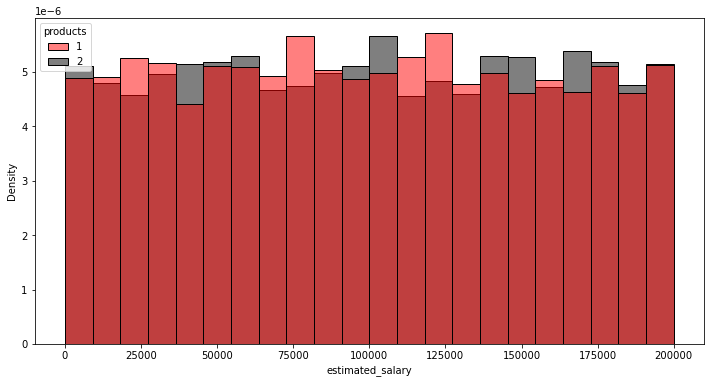

In [66]:
#Visualizing distribution of estimated salary 

print('Differences in Estimated Salary Between Clients Using 1 and 2 Bank Products')
plt.figure(figsize=(12,6))
sns.histplot(data=df.loc[df['products']<3],hue="products",x="estimated_salary",stat="density",common_norm=False,palette="flag")
plt.show()

To confirm the results of client segmentation, let us check statistical hypothesis on equality of churn rate among the clients using one bank product and those using 2 bank products.

Zero hypothesis: Churn rates in groups of clients using one bank product and those using two bank products do not differ.
Alternative hypothesis: Churn rates in groups of clients using one bank product and those using two bank products are different.

Differences in Churn Rates Between Clients Using 1 and 2 Bank Products


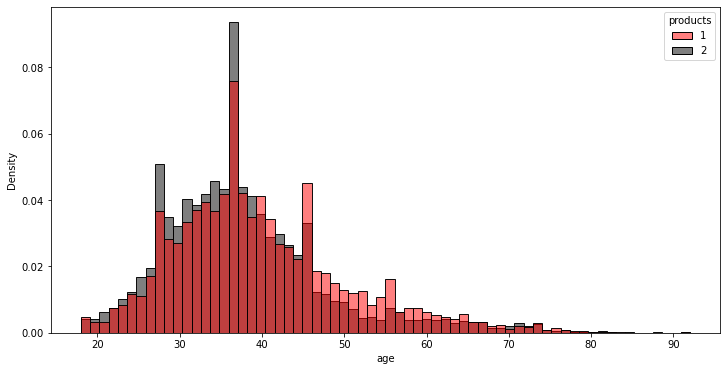

In [67]:
#Visualizing distribution of churn rate 

print('Differences in Churn Rates Between Clients Using 1 and 2 Bank Products')
plt.figure(figsize=(12,6))
sns.histplot(data=df.loc[df['products']<3],hue="products",x="age",stat="density",common_norm=False,palette="flag")
plt.show()

Overall, the distribution of clients in both groups is close to normal, hense, we can use z-test.

In [68]:
#Calculating variables, needed for z-test

left1 = df.loc[df['products']==1]['churn'].sum()
left2 = df.loc[df['products']==2]['churn'].sum()

total1 = df.loc[df['products']==1]['userid'].count()
total2 = df.loc[df['products']==2]['userid'].count()


In [69]:
# Performing z-test

alpha = .05 

left = np.array([left1, left2])
total = np.array([total1, total2])

# churn rate in the first group:
p1 = left[0]/total[0]

# churn rate in the second group:
p2 = left[1]/total[1]

# churn rate in combined dataset:
p_combined = (left[0] + left[1]) / (total[0] + total[1])

# share of churn rates in two groups
difference = p1 - p2 

z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/total[0] + 1/total[1]))

distr = st.norm(0, 1) 

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-value: ', p_value)

if p_value < alpha:
    print('Zero hypothesis rejected: there is statistically significant difference in churn rates')
else:
    print(
        'Zero hypothesis cannot be rejected, churn rates are not statistically different'
    )

p-value:  0.0
Zero hypothesis rejected: there is statistically significant difference in churn rates


During the segmentation of clients differences in churn rates depending on client age were spotted. Inter alia, higher churn rate among clients aged 45-60 was found. Let us check whether these differences are statistically significant.

Zero hypothesis: churn rate among clients aged 45-60 and clients of other ages is not statistically different. 
Alternative hypothesis: churn rate among clients aged 45-60 and clients of other ages is statistically different. 

To check the hypothesis let us use z-test.


In [70]:
#Calculating variables, needed for z-test

left1 = df.loc[df['age_group']=='over middle age']['churn'].sum()
left2 = df.loc[df['age_group']!='over middle age']['churn'].sum()

total1 = df.loc[df['age_group']=='over middle age']['userid'].count()
total2 = df.loc[df['age_group']!='over middle age']['userid'].count()


In [71]:
# Performing z-test

alpha = .05 

left = np.array([left1, left2])
total = np.array([total1, total2])

# churn rate in the first group:
p1 = left[0]/total[0]

# churn rate in the second group:
p2 = left[1]/total[1]

# churn rate in combined dataset:
p_combined = (left[0] + left[1]) / (total[0] + total[1])

difference = p1 - p2 

z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/total[0] + 1/total[1]))

distr = st.norm(0, 1) 

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-value: ', p_value)

if p_value < alpha:
    print('Zero hypothesis rejected: there is statistically significant difference in churn rates')
else:
    print(
        'Zero hypothesis cannot be rejected, churn rates are not statistically different'
    )

p-value:  0.0
Zero hypothesis rejected: there is statistically significant difference in churn rates


**Interim Conclusion**

The results of statistical analysis demonstrate that:
    
    - there are no grounds to suggest that estimated salary among the clients using one bank product and two bank products is different;
    
    - the difference in churn rates between the clients using one bank product and those using 2 bank products is statistically significant;
    
     - the difference in churn rates between the clients aged 45-60 and clients in other age groups is statistically significant.
    
    

## Conclusions and Recommendations

**Краткое описание проведенной работы**

*Project Objective*

Develop proposals aimed at improving retention of bank clients.

*Project Tasks* included

•	conducting exploratory data analysis of bank clients, 

•	conducting client segmentation based on using bank products and other factors,

•	checking hypotheses on the reasons for clients to churn,

•	formulating recommendations for improving client retention.

*Initial Data*

Dataset which included the data on 10,000 bank clients from 3 cities (credit scoring data, city, gender, age, number of property objects, credit card availability, loyalty, salary estimate, churn).


At the stage of *preliminary data processing* no instances of incorrect data or duplicates were identified. However, missing data was identified in 'account balance' column (data is present for 6383 clients out of 10000). 

The gap analysis has demonstrated that some data on account balance is missed for clients from 2 out of 3 branches of the bank (branches in Yaroslavl and Rybinsk). The fact of missing data does not depend on client churn, loyalty, number of bank products used, use of credit card, age, estimated salary or credit score

Possibly the data on account balance has been added to the database in Yaroslavl and Rybinsk recently, hence, for some clients this data is missing.

Estimated salary, client age and credit rating do not correlate with client account balance. Hense, these variable cannot be used for filling in the gaps. Missing data on account balance accounts for considerable portion of the total dataset; excluding these clients for further research may lead to incorrect conclusions. 

Based on *exploratory data analysis* the following conclusions were formulated:

- The age of bank clients varies from 18 to 92. Median client age is 37. There are substantial differences among retained clients and churned clients: median age of churned clients is 45 years old; half of the clients that left the bank were between 38 and 52 years old. This trend is true both for men and women. 

- The highest churn rate is in the 'over middle age' group (between 45 and 60 years old). In this group the number of churned clients is higher than the number of retained clients.

- Weak correlation between client age and churn risk is confirmed by the results of correlation analysis: correlation coefficient between these factors is 0.285 which demonstrates weak positive correlation between the client age and churn risk.

- The highest churn rate in relative and absolute terms is seen in Rostov the Great: 814 clients in this city (or about a third of total number of clients) have left the bank in this city. Significant client churn is also seen in Yaroslavl (810 clients). In relative terms, the situation in Yaroslavl and Rybinsk is similar.

- Bank clients have credit score varying from 350 to 850 points. Median credit score is 652 points. Noteworthy, credit score among churned clients is slightly lower than among the clients retained by the bank (median credit score among the churned clients accounts for 646 points and median score among retained clients reaches 653 points).

- Median estimated salary of bank clients included into the dataset accounts for some 100193,9 RUR/month. Median estimated salary among the churned clients is slightly higher (102460.84 RUR), than among the remained clients (99645,04 RUR). Noteworthy, that differences in estimated salary among the churned and retained clients are relevant only for female clients. 

- Churn of clients is present in all groups irrespective of salary estimates. In relative terms a slightly higher churn is noted among the clients with high estimated salary.

- Bank clients use from 1 to 4 products. Median number of products used both by the retained clients and by the clients that left the bank is 1. 90% of bank clients use 2 bank products and less. Only some churned clients used 4 bank products (60 clients out of 10K dataset).

- Such uneven distribution of clients suggests that during the client segmentation it is expedient to unite clients using 3 and 4 products into one group.

- In relative terms the highest churning rate is seen among the clients that used 3 or 4 bank products. The lowest churning rate is among the clients that used only 2 products. 
    

**Bank Client Segments**

Based on the segmentation results, the following bank client groups were defined (by the urgency of addressing client churn issue):

1. *Group requiring immediate attention* includes clients using 3-4 bank products. The group is characterized by the highest churn rate (85.9%) while the group itself is not very large (3.3% of total dataset). Average client age in this group is 43.7 years old, average credit score is 649.1 points, some 43,5% of group clients are rated as loyal, average salary estimate accounts for 104,4K RUR. 

It is likely that the high churn rate in this group is related to more attractive products and loyalty programs proposed by competitors. It is recommended to develop a special loyalty program for the clients using more than 2 bank products. 

2. *Group requiring high attention* includes bank clients aged 45 to 60 that use only one bank product. The churn rate in this group accounts for 60.9%. The group is characterized by slightly lower level of average credit score (646.86 points). The group accounts for some 10 percent bank clients.

It is likely that high churn rate in this group is related to the absence of attractive bank projects for the age category in question. It is recommended to consider a possibility for developing special products for clients aged 45+, including credit instruments. 

3. *Groups requiring attention* include client segments with churn rates ranging from 10% to 30.1% (overall these segments account for some 48.2% of the bank clients included into the dataset). The groups requiring attention include:

- *Loyal mature clients* - clients aged between 45 and 60 using 2 bank products. The churn rate in this group accounts for some 23.6%, loyalty rate is 62.6%, average credit rating is 647 points. The churn rate in this group is the highest among the clients using 2 bank products. Retaining such clients may be supported by special products (including credit products) for clients aged 45+. 

- *Loyal pensioniers* - clients in pension age using 2 bank products. Churn rate in this group accounts for 12.8% (lower than average in the bank), loyalty rate is 88.2%, average account balance is 121.6K RUR. To reduce churn rate in this group introduction of special products for pensioniers may be considered.

- *Relatively loyal clients aged below 45* - clients younger than 45 years old using 1 bank product. The churn rate in this group is 20.9% for middle age clients and 10.8% for young clients. Average credit rating accounts for 649 points. Retaining this clients would call for developing a loyalty program: the analysis demonstrates that clients using 2 bank products tend to be retained more frequently.

- *Pensioniers at-rist* - clients of 60+ age using one bank product. The churn rate in the group reaches 30.1%, loyalty rate is 77.5%, average account balance is 117.6K RUR. To retain these clients, it is recommended to consider special bank products oriented at pensioniers. These programs are especially relevant given that some large banks have introduced bonus programs for transferring pensions.

4. *Most loyal group* - includes clients younger than 45 years old using 2 bank products. The group accounts for 38.5% of total bank clients. The churn rate in the group does not exceed 6%. Average credit score is 652 points, average balance account equals  99.7K RUR, the share of clients rated as loyal is about 50%.

The results of bank segmentation also suggests that there might be a need to revise the internal definition of 'loyal' clients (i.e. review the conditions of rating a certain client as loyal). As demonstrated by the above analysis, a high share of loyal segments (as rated internally) does not necessarily translate into lower churn rates and vice versa.

**Statistical Analysis Results**

The results of statistical analysis demonstrate that:
    
    - there are no grounds to suggest that estimated salary among the clients using one bank product and two bank products is different;
    
    - the difference in churn rates between the clients using one bank product and those using 2 bank products is statistically significant;
    
     - the difference in churn rates between the clients aged 45-60 and clients in other age groups is statistically significant.

**Recommendations on Retaining Bank Clients**

1. To decrease bank client churn rate it is recommended to pay special attention to the clients using 3-4 bank products. The analysis demonstrates that the churn rate among this client group is exceptionally high. This is likely to the absence (or inatractiveness) of a bank loyalty program compared to premium programs offered by competitors (i.e. other banks). Such loyalty program could inter alia include higher deposit and lower credit rates for the clients actively using bank products.

2. Special attention should be paid to the needs of the clients aged 45-60, especially those using only one bank product. High churn rate among such clients may result from the absence of a special bank products for this category of clients and also stricter criteria used for approving credit products compared to those offered by other banks (such hypothesis stems from the fact that credit score among the clients in this category is lower). A possible solution would entail introducing a special 45+ credit line for bank clients aged 45 and older who have not retired yet. 

3. Significant churn rate among clients in retirement age (especially those using only one bank product) may be related to one-off bonuses offered by other banks for pension transfer. To counteract these bonus programs the bank could provide a special offer for retired clients, for instance, a cashback card. 

4. To reduce churn rate among the 'relatively loyal clients aged up to 45' that use only one bank product, it is recommended to promote existing bank products more actively and offer some bonuses for adding the second bank product. This would contribute to increasing the share of the most loyal bank clients.